**Text Classification Project**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading dataset
data = pd.read_csv('US-Economic-News.csv', encoding = 'ISO-8859-1')
display(data.shape)

(8000, 15)

**Exploratory Data Analysis (EDA)**

In [3]:
# Record Distribution
data["relevance"].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [4]:
data = data[data.relevance != "not sure"]
data.shape

(7991, 15)

In [5]:
data["relevance"].value_counts()/data.shape[0]

no     0.8223
yes    0.1777
Name: relevance, dtype: float64

In [6]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data
 ['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values"
)
fig.show()

**Text Preprocessing**

In [7]:
# Replacing values to numbers
data['relevance'] =  data.relevance.map({'yes':1, 'no':0})
data =data[["text", "relevance"]]

data = data[:1000]
data.shape

(1000, 2)

In [8]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [ ]:
data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

Text Cleaning

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ")
    doc = doc.replace("-", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [10]:
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.corpus
def clean(doc):
  #..
  #
  doc = "".join([WordNetLemmatizer().lemmatize(word) for word in doc])
  return doc

clean(data['text'][0])

[nltk_data] Downloading package wordnet to /root/nltk_data...


'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [11]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


**TF-IDF Vectorizer**

In [12]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [13]:
X = docs
y = data['relevance']
print(X.shape, y.shape)

(1000, 14552) (1000,)


In [14]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

Train-Test Split

In [15]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 14552) (800,)
(200, 14552) (200,)


Naive Bayes Classifier

Gaussian Naive Bayes

In [16]:
gnb = GaussianNB()
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 141 ms, sys: 87.2 ms, total: 228 ms
Wall time: 264 ms

Training Accuracy score: 0.9975
Testing Accuracy score: 0.75


In [17]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.96      0.85       151
    relevant       0.45      0.10      0.17        49

    accuracy                           0.75       200
   macro avg       0.61      0.53      0.51       200
weighted avg       0.69      0.75      0.68       200



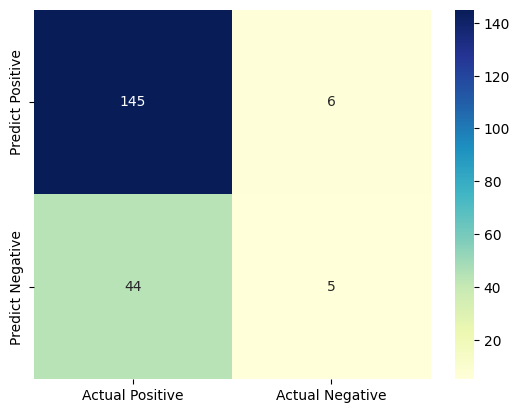

In [18]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

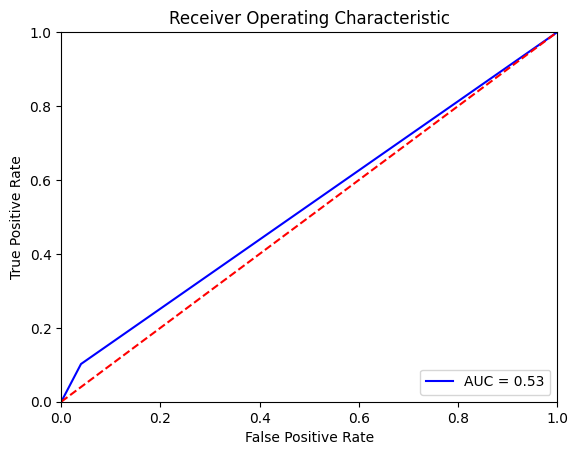

In [19]:
probs = gnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Multinomial Naive Bayes

In [20]:
mnb = MultinomialNB()
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 66.1 ms, sys: 3.7 ms, total: 69.8 ms
Wall time: 123 ms

Training Accuracy score: 0.7575
Testing Accuracy score: 0.755


In [21]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.76      1.00      0.86       151
    relevant       0.00      0.00      0.00        49

    accuracy                           0.76       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.76      0.65       200



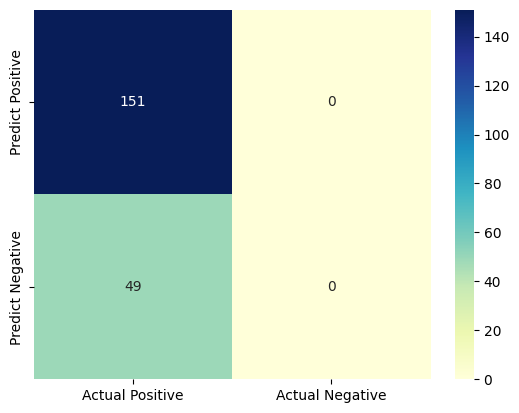

In [22]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

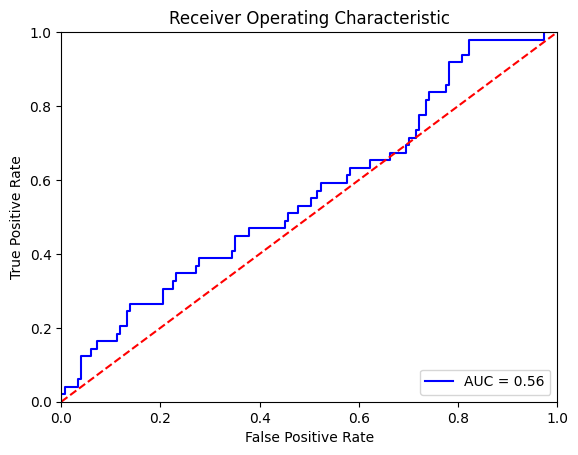

In [23]:
probs = mnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Multinomial Naive Bayes performs slightly better than Gaussian Naive Bayes, but the low AUC score is because the size of feature vector is really big and Bayes Algorothm works better for small number of features. Let's check out results of Logistic Regression, Support Vector Machines and Decision Tree Classifier.


**Logistic Regression Classifier**

In [24]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 967 ms, sys: 511 ms, total: 1.48 s
Wall time: 1.25 s

Training Accuracy score: 0.8
Testing Accuracy score: 0.765


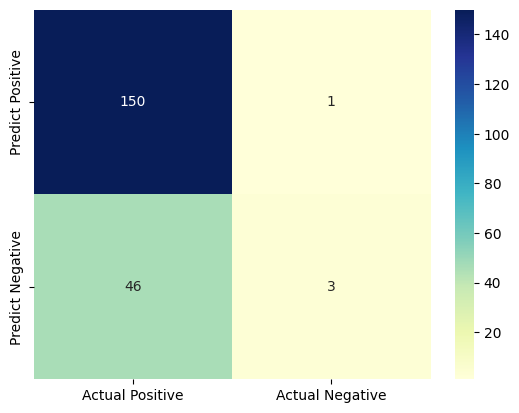

In [25]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [26]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.75      0.06      0.11        49

    accuracy                           0.77       200
   macro avg       0.76      0.53      0.49       200
weighted avg       0.76      0.77      0.68       200



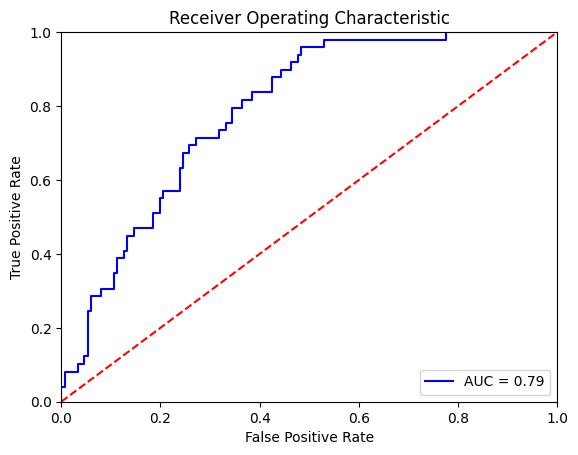

In [27]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Support Vector Machines

In [29]:
svc =  LinearSVC(class_weight='balanced')
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 95.2 ms, sys: 4.37 ms, total: 99.6 ms
Wall time: 112 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.74


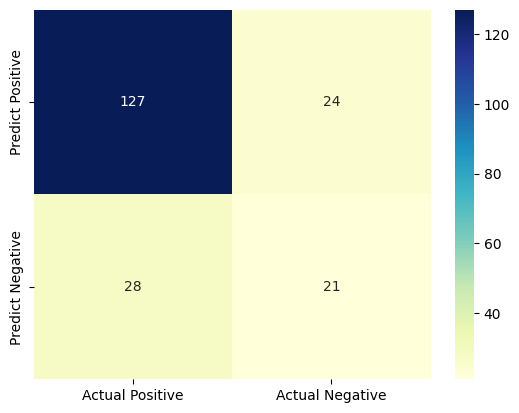

In [30]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [31]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.82      0.84      0.83       151
    relevant       0.47      0.43      0.45        49

    accuracy                           0.74       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.73      0.74      0.74       200



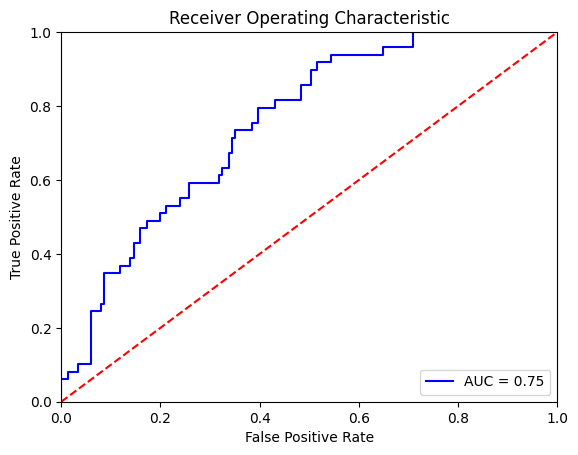

In [32]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Tree Classifier

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 2.89 s, sys: 22.4 ms, total: 2.92 s
Wall time: 3.77 s

Training Accuracy score: 1.0
Testing Accuracy score: 0.69


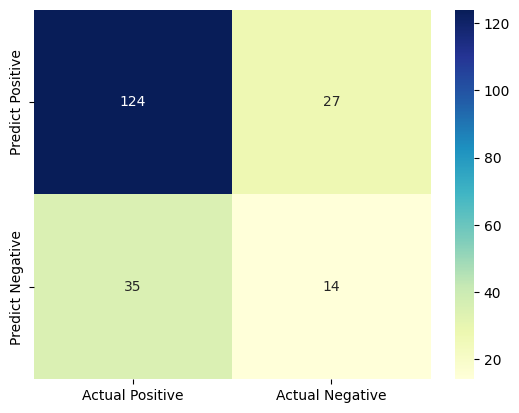

In [34]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [35]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.78      0.82      0.80       151
    relevant       0.34      0.29      0.31        49

    accuracy                           0.69       200
   macro avg       0.56      0.55      0.56       200
weighted avg       0.67      0.69      0.68       200



Ensembling

In [36]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
                ('Naive Bayes', gnb)
              ]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)
y_pred_train=vc.predict(X_train)
y_pred_test = vc.predict(X_test)
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 1.0
Testing Accuracy score: 0.765


In [37]:
predictions = pd.Series(vc.predict(X), name="relevant")
results = pd.concat([predictions],axis=1)
results.to_csv("us-economic-news-relevance.csv",index=False)